# EDA_Segment_Preparation_for_....ipynb 비교

- EDA_Segment_Preparation_for_Recommendation.ipynb
  - 세그먼트 구할 때, 유통사 정보(상품구매정보)만 이용
- EDA_Segment_Preparation_for_LGBM.ipynb
  - 세그먼트 구할 때, (유통사+제휴사) 통합한 정보

In [ ]:
# 1단계 (다운완료)
!apt install fonts-nanum
!ls /usr/share/fonts/truetype/nanum/

# 2단계
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font = fm.FontProperties(fname=font_path, size=9)
fm._rebuild()

# 3단계 (수동으로 런타임 재시작을 안 해도 됨, 실행버튼은 다시 눌러야 함.)
import os
os.kill(os.getpid(), 9)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (15.3 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 155680 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumBarunGothicBold.ttf  NanumMyeongjoBold.ttf  NanumSquareRoundR.ttf
NanumBarunGothic

# "실행버튼 다시 눌러야함"
- 나눔폰트 다운받고, os.kill(os.getpid(),9)에 의해 런타임 중단됐음

# 준비

- 나눔고딕 폰트 설치
- 구글 드라이브 연결
- 데이터 로딩

In [4]:
import pandas as pd
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=font_path, size=9).get_name()
fm._rebuild()

In [5]:
# plt.rcParams['font.family'] = 'NanumGothic'
sns.set(font="NanumGothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize': (10,6)},
        style='darkgrid')
# sns.set_theme(style="whitegrid")

In [6]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [7]:
base_path = "/gdrive/MyDrive/Colab Notebooks/LPOINT_BIG_COMP/LPOINT_BIG_COMP_csv_agg/"

In [8]:
file_path_dic = {
    'demo':'LPOINT_BIG_COMP_01_DEMO.csv',
    'pdde':'LPOINT_BIG_COMP_02_PDDE.csv',
    'cop_u':'LPOINT_BIG_COMP_03_COP_U.csv',
    'pd_clac':'LPOINT_BIG_COMP_04_PD_CLAC.csv',
    'br':'LPOINT_BIG_COMP_05_BR.csv',
    'lpay':'LPOINT_BIG_COMP_06_LPAY.csv',
}

## demo: 고객 데모 정보

In [9]:
df_demo = pd.read_csv(os.path.join(base_path, file_path_dic['demo']))

## 상품 분류 정보: 유통사 상품 카테고리 마스터

In [10]:
df_pd_clac = pd.read_csv(os.path.join(base_path, file_path_dic['pd_clac']))

In [11]:
df_pd_clac.describe()

,pd_c,pd_nm,clac_hlv_nm,clac_mcls_nm
count,1933,1933,1933,1933
unique,1933,1932,60,349
top,PD0001,기타,패션잡화,어류
freq,1,2,130,20


## 점포 정보: 유통사/제휴사 점포 마스터

In [12]:
df_br = pd.read_csv(os.path.join(base_path, file_path_dic['br']))

## 제휴사 이용 정보: 제휴사 이용 내역

In [13]:
df_cop_raw = pd.read_csv(os.path.join(base_path, file_path_dic['cop_u']), dtype={'br_c':str, 'de_dt':str, 'de_hr':str, 'buy_am':np.int64})

In [14]:
print(df_cop_raw.shape, df_cop_raw.duplicated().sum())

(248304, 9) 0


In [15]:
df_cop_raw.head()

,cust,rct_no,cop_c,br_c,chnl_dv,de_dt,vst_dt,de_hr,buy_am
0,M839993508,21102612B015763935,B01,B010012,1,20211026,20211026,12,60000
1,M839993508,21110610B014219744,B01,B010012,1,20211106,20211106,10,17100
2,M839993508,21021112B013419710,B01,B010012,1,20210211,20210211,12,136500
3,M839993508,21092010B012637545,B01,B010012,1,20210920,20210920,10,34200
4,M839993508,21101009D015920171,D01,D010614,1,20211010,20211010,9,2500


In [16]:
df_cop_raw['de_dthr'] = df_cop_raw.de_dt + df_cop_raw.de_hr

#### 사용자 관점 트랜잭션/결제 횟수 분포

사용자별 결제건수
- 중간값: 10번
- 평균값: 11.4번

사용자별 총결제금액
- 중간값: 103,000원
- 평균값: 229,616.6원

In [17]:
def show_simple_ecdf_from_value_counts(ss, x_label='cnts', y_label='prob', kind='scatter', title='', logx=False,):
    y = (ss.cumsum() / ss.sum()).rename(y_label)
    pd.DataFrame(y.rename_axis(x_label).reset_index()).plot(kind=kind, title=title, x=x_label, y=y_label, ylim=[0,1], logx=logx)
    print(f'Most frequent case is {y.index[0]} with pct {y.iloc[0]*100:.2f}%')

Most frequent case is 1 with pct 15.29%


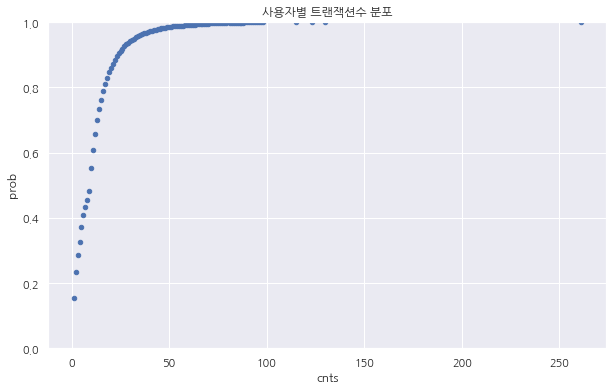

In [18]:
show_simple_ecdf_from_value_counts(df_cop_raw.cust.value_counts().value_counts().sort_index(), title='사용자별 트랜잭션수 분포')

In [19]:
pd.DataFrame(df_cop_raw.groupby('cust').rct_no.nunique().describe()).T

,count,mean,std,min,25%,50%,75%,max
rct_no,21769.0,11.406312,11.610991,1.0,3.0,10.0,15.0,261.0


In [20]:
pd.DataFrame(df_cop_raw.groupby('cust').buy_am.sum().describe()).T

,count,mean,std,min,25%,50%,75%,max
buy_am,21769.0,229616.590289,992180.995583,500.0,34000.0,103000.0,208540.0,78419611.0


### 전처리 (속성 추가)
- cust_uniq_rct_nos: 고객별 영수증(건수)
- cust_total_payments: 고객별 총 금액
- rct_no_payment: 영수증별 합계 금액
- de_dthr = de_dt + de_hr

In [21]:
df_cop_raw['cust_uniq_rct_nos'] = df_cop_raw.groupby('cust').rct_no.transform('nunique')

In [22]:
df_cop_raw['cust_total_payments'] = df_cop_raw.groupby('cust').buy_am.transform('sum')

In [23]:
df_cop_raw['rct_no_payment'] = df_cop_raw.groupby(['rct_no']).buy_am.transform('sum')

In [24]:
df_cop_raw['de_dthr'] = pd.to_datetime(df_cop_raw.de_dt.str.cat(df_cop_raw.de_hr), format='%Y%m%d%H')
df_cop_raw.drop(labels=['de_dt', 'de_hr'], axis=1, inplace=True)

In [25]:
df_cop_raw.head()

,cust,rct_no,cop_c,br_c,chnl_dv,vst_dt,buy_am,de_dthr,cust_uniq_rct_nos,cust_total_payments,rct_no_payment
0,M839993508,21102612B015763935,B01,B010012,1,20211026,60000,2021-10-26 12:00:00,11,379413,60000
1,M839993508,21110610B014219744,B01,B010012,1,20211106,17100,2021-11-06 10:00:00,11,379413,17100
2,M839993508,21021112B013419710,B01,B010012,1,20210211,136500,2021-02-11 12:00:00,11,379413,136500
3,M839993508,21092010B012637545,B01,B010012,1,20210920,34200,2021-09-20 10:00:00,11,379413,34200
4,M839993508,21101009D015920171,D01,D010614,1,20211010,2500,2021-10-10 09:00:00,11,379413,2500


## 상품 구매 정보: 유통사 상품 구매 내역

In [26]:
df_pdde_raw = pd.read_csv(os.path.join(base_path, file_path_dic['pdde']), dtype={'br_c':str, 'de_dt':str, 'de_hr':str, 'buy_am':np.int64})

In [27]:
print(df_pdde_raw.shape, df_pdde_raw.duplicated().sum())

(4381743, 10) 237354


In [28]:
df_pdde_raw.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000,1
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000,1
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000,1
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000,1


### 장바구니 단순 특성 조사
- (cust, chnl_dv, cop_c, br_c, de_dthr)로 고유 장바구니가 만들어짐
- 한 장바구니에 여러 상품이 들어있는 개념으로, 장바구니 번호가 같은 여러 트래잭션들은 (pd_c, buy_am, buy_ct)의 조합이 달라짐.

In [29]:
gr_rct_no = df_pdde_raw.groupby(['rct_no'])

In [30]:
df_pdde_raw['de_dthr'] = df_pdde_raw.de_dt + df_pdde_raw.de_hr

In [31]:
print("장바구니에 담긴 cop_c가 2개이상인 경우의 갯수", (gr_rct_no.cop_c.nunique() > 1).sum())

장바구니에 담긴 cop_c가 2개이상인 경우의 갯수 0


In [32]:
print("장바구니에 담긴 br_c가 2개이상인 경우의 갯수", (gr_rct_no.br_c.nunique() > 1).sum())

장바구니에 담긴 br_c가 2개이상인 경우의 갯수 0


In [33]:
print("장바구니에 담긴 chnl_dv가 2개이상인 경우의 갯수", (gr_rct_no.chnl_dv.nunique() > 1).sum())

장바구니에 담긴 chnl_dv가 2개이상인 경우의 갯수 0


In [34]:
print("장바구니에 담긴 de_dthr가 2개이상인 경우의 갯수", (gr_rct_no.de_dthr.nunique() > 1).sum())

장바구니에 담긴 de_dthr가 2개이상인 경우의 갯수 0


#### 사용자 관점 트랜잭션/결제 횟수 분포
- 트랙젝션수 분포와 결제 횟수(장바구니) 분포 비교

사용자별 결제건수
- 중간값: 30번
- 평균값: 47번

사용자별 총결제금액
- 중간값: 1.4 백만원
- 평균값: 3.8 백만원


Most frequent case is 1 with pct 3.84%


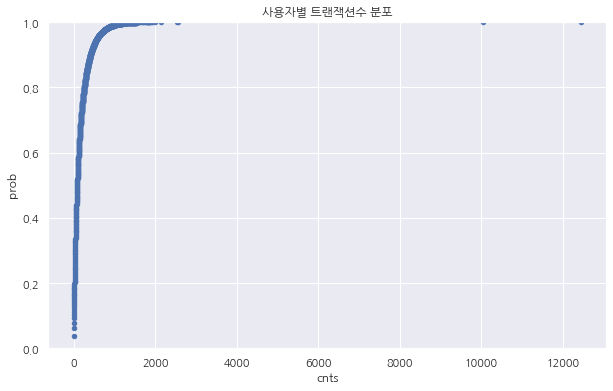

In [35]:
show_simple_ecdf_from_value_counts(df_pdde_raw.cust.value_counts().value_counts().sort_index(), title='사용자별 트랜잭션수 분포')

In [36]:
pd.DataFrame(df_pdde_raw.groupby('cust').rct_no.nunique().describe()).T

,count,mean,std,min,25%,50%,75%,max
rct_no,26917.0,47.055355,55.997831,1.0,14.0,30.0,62.0,3027.0


Most frequent case is 1 with pct 6.04%


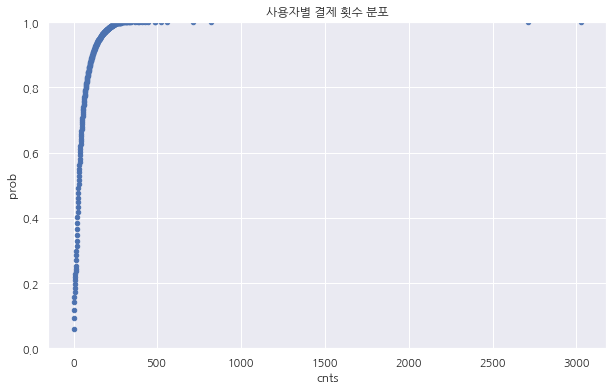

In [37]:
show_simple_ecdf_from_value_counts(df_pdde_raw.groupby('cust').rct_no.nunique().value_counts().sort_index(), title='사용자별 결제 횟수 분포')

In [38]:
pd.DataFrame(df_pdde_raw.groupby('cust').buy_am.sum().describe()).T

,count,mean,std,min,25%,50%,75%,max
buy_am,26917.0,3.778704e+06,1.168812e+07,10.0,479730.0,1405659.0,3323329.0,386581410.0


Most frequent case is 10 with pct 0.00%


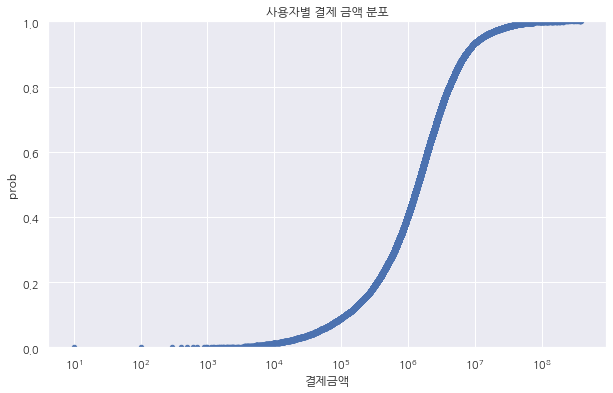

In [39]:
show_simple_ecdf_from_value_counts(df_pdde_raw.groupby('cust').buy_am.sum().value_counts().sort_index(), x_label='결제금액', title='사용자별 결제 금액 분포', logx=True)

#### 장바구니에 담긴 pd_c 를 조사

- 다양성
    - 약 60%는 1가지만
    - 약 75가지 담기는 경우도 존재
- 트랜잭션 수
    - 약 50%는 1건
    - 최대 120건도 존재

Most frequent case is 1 with pct 58.18%


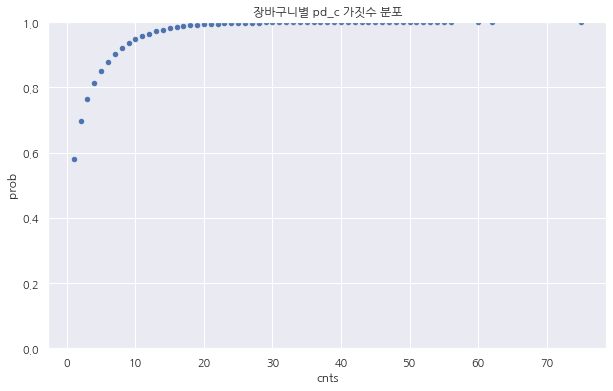

In [40]:
show_simple_ecdf_from_value_counts(gr_rct_no.pd_c.nunique().value_counts().sort_index(), title='장바구니별 pd_c 가짓수 분포')

Most frequent case is 1 with pct 50.26%


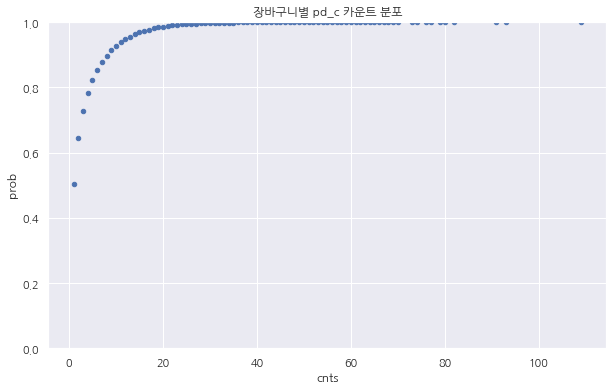

In [41]:
show_simple_ecdf_from_value_counts(gr_rct_no.pd_c.count().value_counts().sort_index(), title='장바구니별 pd_c 카운트 분포')

#### [rct_no, pd_c] 를 조사

- buy_am의 다양성
    - 약 90%는 1가지
    - 약 19가지도 존재
- buy_ct의 다양성
    - 약 95%는 1가지
    - 8가지도 존재

Most frequent case is 1 with pct 91.42%


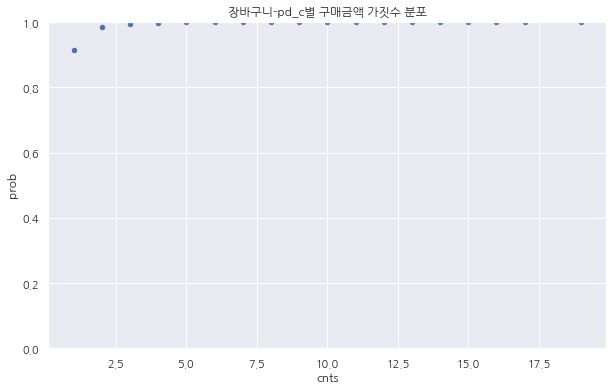

In [42]:
show_simple_ecdf_from_value_counts(df_pdde_raw.groupby(['rct_no', 'pd_c']).buy_am.nunique().value_counts().sort_index(), title='장바구니-pd_c별 구매금액 가짓수 분포')

Most frequent case is 1 with pct 97.31%


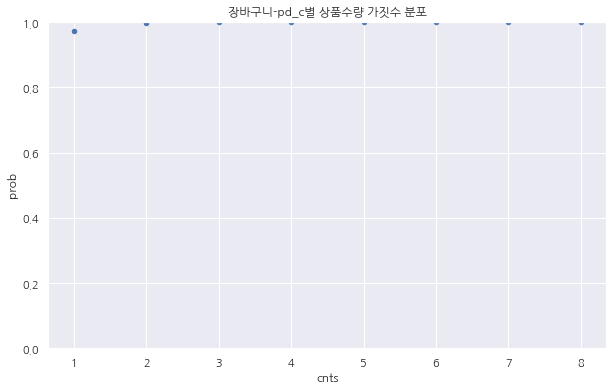

In [43]:
show_simple_ecdf_from_value_counts(df_pdde_raw.groupby(['rct_no', 'pd_c']).buy_ct.nunique().value_counts().sort_index(), title='장바구니-pd_c별 상품수량 가짓수 분포')

Most frequent case is 1 with pct 87.75%


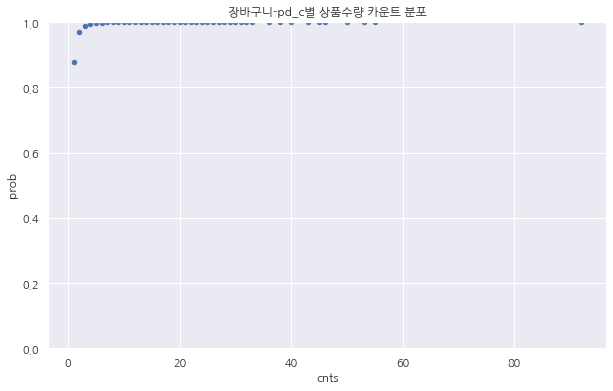

In [44]:
show_simple_ecdf_from_value_counts(df_pdde_raw.groupby(['rct_no', 'pd_c']).buy_ct.count().value_counts().sort_index(), title='장바구니-pd_c별 상품수량 카운트 분포')

In [45]:
df_pdde_raw['cust_uniq_rct_nos'] = df_pdde_raw.groupby('cust').rct_no.transform('nunique')

In [46]:
df_pdde_raw['cust_total_payments'] = df_pdde_raw.groupby('cust').buy_am.transform('sum')

In [47]:
df_pdde_raw['rct_no_uniq_pd_cs'] = df_pdde_raw.groupby(['rct_no']).pd_c.transform('nunique')

In [48]:
df_pdde_raw['rct_no_pd_cs'] = df_pdde_raw.groupby(['rct_no']).pd_c.transform('count')

In [49]:
df_pdde_raw['rct_no_payment'] = df_pdde_raw.groupby(['rct_no']).buy_am.transform('sum')

In [50]:
df_pdde_raw['de_dthr'] = pd.to_datetime(df_pdde_raw.de_dt.str.cat(df_pdde_raw.de_hr), format='%Y%m%d%H')
df_pdde_raw.drop(labels=['de_dt', 'de_hr'], axis=1, inplace=True)

In [51]:
df_pdde_raw.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,buy_am,buy_ct,de_dthr,cust_uniq_rct_nos,cust_total_payments,rct_no_uniq_pd_cs,rct_no_pd_cs,rct_no_payment
0,M430112881,A01000001113,1,A01,A010039,PD0290,15000,1,2021-01-01 10:00:00,102,2977947,1,1,15000
1,M646853852,A01000002265,1,A01,A010025,PD1369,79700,1,2021-01-01 10:00:00,97,9165313,1,1,79700
2,M430112881,A01000003148,1,A01,A010039,PD0290,19000,1,2021-01-01 10:00:00,102,2977947,1,2,38000
3,M430112881,A01000003148,1,A01,A010039,PD0290,19000,1,2021-01-01 10:00:00,102,2977947,1,2,38000
4,M430112881,A01000004946,1,A01,A010039,PD0290,19000,1,2021-01-01 10:00:00,102,2977947,1,1,19000


---

## 유통사 + 제휴사 테이블 합치기

In [52]:
df_raw = pd.concat([df_pdde_raw, df_cop_raw])
df_raw

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,buy_am,buy_ct,de_dthr,cust_uniq_rct_nos,cust_total_payments,rct_no_uniq_pd_cs,rct_no_pd_cs,rct_no_payment,vst_dt
0,M430112881,A01000001113,1,A01,A010039,PD0290,15000,1.0,2021-01-01 10:00:00,102,2977947,1.0,1.0,15000,NaN
1,M646853852,A01000002265,1,A01,A010025,PD1369,79700,1.0,2021-01-01 10:00:00,97,9165313,1.0,1.0,79700,NaN
2,M430112881,A01000003148,1,A01,A010039,PD0290,19000,1.0,2021-01-01 10:00:00,102,2977947,1.0,2.0,38000,NaN
3,M430112881,A01000003148,1,A01,A010039,PD0290,19000,1.0,2021-01-01 10:00:00,102,2977947,1.0,2.0,38000,NaN
4,M430112881,A01000004946,1,A01,A010039,PD0290,19000,1.0,2021-01-01 10:00:00,102,2977947,1.0,1.0,19000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248299,M058650684,21111614C021426818,1,C02,C020002,NaN,2000,NaN,2021-11-16 14:00:00,5,75000,NaN,NaN,2000,20211116.0
248300,M058650684,21111619C023223432,1,C02,C020002,NaN,26900,NaN,2021-11-16 19:00:00,5,75000,NaN,NaN,26900,20211116.0
248301,M014154595,21121209C015324520,2,C01,C010087,NaN,2000,NaN,2021-12-12 09:00:00,3,6000,NaN,NaN,2000,20211212.0
248302,M510878172,21112719C013369102,2,C01,C010007,NaN,6000,NaN,2021-11-27 19:00:00,2,12300,NaN,NaN,6000,20211127.0


In [53]:
print(df_demo.cust.nunique())   # 엘페이 이용 정보만 있는 고객의 경우: (29913 - 29756)명
print(df_raw.cust.nunique())
print(df_pdde_raw.cust.nunique())
print(df_cop_raw.cust.nunique())

29913
29756
26917
21769


In [54]:
print(df_raw.isnull().sum())

cust                         0
rct_no                       0
chnl_dv                      0
cop_c                        0
br_c                    428556
pd_c                    248304
buy_am                       0
buy_ct                  248304
de_dthr                      0
cust_uniq_rct_nos            0
cust_total_payments          0
rct_no_uniq_pd_cs       248304
rct_no_pd_cs            248304
rct_no_payment               0
vst_dt                 4381743
dtype: int64


# RFM 세그먼트

## 마진 설정

In [55]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.00)    
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [56]:
replace_with_thresholds(df_raw, 'rct_no_payment')

## RFM

In [57]:
# 장바구니별로 groupby
df_crm = (df_raw.groupby(['rct_no'])
         .agg({'cust':'first', 'de_dthr':'first', 'rct_no_payment':'first'})
         .sort_values(by='de_dthr', ascending=True)
         .reset_index()
         .rename(columns={'rct_no_payment':'buy_am'})
)
df_crm

,rct_no,cust,de_dthr,buy_am
0,20122713C012328716,M495972460,2020-12-27 13:00:00,26000.0
1,20122900C013317930,M192531170,2020-12-29 00:00:00,10000.0
2,20122911C011862577,M039320884,2020-12-29 11:00:00,6500.0
3,20123009C012921880,M201983289,2020-12-30 09:00:00,24000.0
4,20123012C011060420,M205977381,2020-12-30 12:00:00,6500.0
...,...,...,...,...
1514888,A04129060293,M583757333,2021-12-31 23:00:00,14600.0
1514889,E03012401343,M655525572,2021-12-31 23:00:00,60080.0
1514890,A04128847016,M326961541,2021-12-31 23:00:00,31150.0
1514891,A04129053601,M452775982,2021-12-31 23:00:00,7700.0


In [58]:
df_crm.isnull().sum()

rct_no     0
cust       0
de_dthr    0
buy_am     0
dtype: int64

## 상반기 하반기 데이터 나누기
- 상반기는 2,474,431건
- 하반기는 2,155,616건

In [59]:
half = '2021-07-01'

# 상반기 데이터: df_first_half, 하반기 데이터: df_second_half
df_first_half = df_raw.query('de_dthr < @half ')
df_second_half = df_raw.query('de_dthr >= @half')

### 상반기

In [60]:
# 상반기 장바구니별로 groupby
df_crm_first = (df_first_half.groupby(['rct_no'])
         .agg({'cust':'first', 'de_dthr':'first', 'rct_no_payment':'first'})
         .sort_values(by='de_dthr', ascending=True)
         .reset_index()
         .rename(columns={'rct_no_payment':'buy_am'})
)

#상반기의 recency는 2021.7.1을 기준으로 함
most_recent_date =pd.Timestamp("2021-07-01")
df_crm_first = (df_crm_first.groupby(['cust'])
          .agg({'de_dthr': lambda date: (most_recent_date - date.max()).days,
                'rct_no': lambda num: num.nunique(), 'buy_am':'sum'})
          .astype({'buy_am':'int'})
)
df_crm_first.columns = ['recency', 'frequency', 'monetary']


# 5등급으로 나눔
df_crm_first["recency_score"] = pd.qcut(df_crm_first['recency'], 5, labels=[5, 4, 3, 2, 1])
df_crm_first["frequency_score"] = pd.qcut(df_crm_first['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
df_crm_first["monetary_score"] = pd.qcut(df_crm_first['monetary'], 5, labels=[1, 2, 3, 4, 5])

#datatype 형변환
df_crm_first[['recency_score','frequency_score','monetary_score']] = df_crm_first[['recency_score','frequency_score','monetary_score']].astype(int)

df_crm_first['rfm_score'] = ((0.3*df_crm_first['recency_score'] + 0.2*df_crm_first['frequency_score'] + 0.5*df_crm_first['monetary_score']) * 100 / 5).astype(int)

#기타:0-39점, 일반:40-59점, 우수:60-79점, 최우수:80-100점
df_crm_first["rfm_level"] = pd.cut(df_crm_first["rfm_score"], bins=4, right=False, labels=['기타고객','일반고객','우수고객','최우수고객'])

### 하반기

In [61]:
# 상반기 장바구니별로 groupby
df_crm_second = (df_second_half.groupby(['rct_no'])
         .agg({'cust':'first', 'de_dthr':'first', 'rct_no_payment':'first'})
         .sort_values(by='de_dthr', ascending=True)
         .reset_index()
         .rename(columns={'rct_no_payment':'buy_am'})
)

#하반기의 recency는 2022.1.1을 기준으로 함
most_recent_date =pd.Timestamp("2022-01-01")
df_crm_second = (df_crm_second.groupby(['cust'])
          .agg({'de_dthr': lambda date: (most_recent_date - date.max()).days,
                'rct_no': lambda num: num.nunique(), 'buy_am':'sum'})
          .astype({'buy_am':'int'})
)
df_crm_second.columns = ['recency', 'frequency', 'monetary']


# 5등급으로 나눔
df_crm_second["recency_score"] = pd.qcut(df_crm_second['recency'], 5, labels=[5, 4, 3, 2, 1])
df_crm_second["frequency_score"] = pd.qcut(df_crm_second['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
df_crm_second["monetary_score"] = pd.qcut(df_crm_second['monetary'], 5, labels=[1, 2, 3, 4, 5])

#datatype 형변환
df_crm_second[['recency_score','frequency_score','monetary_score']] = df_crm_second[['recency_score','frequency_score','monetary_score']].astype(int)

df_crm_second['rfm_score'] = ((0.3*df_crm_second['recency_score'] + 0.2*df_crm_second['frequency_score'] + 0.5*df_crm_second['monetary_score']) * 100 / 5).astype(int)

#기타:0-39점, 일반:40-59점, 우수:60-79점, 최우수:80-100점
df_crm_second["rfm_level"] = pd.cut(df_crm_second["rfm_score"], bins=4, right=False, labels=['기타고객','일반고객','우수고객','최우수고객'])

### 상반기와 하반기 join

In [62]:
df_join = pd.merge(df_crm_first, df_crm_second, left_index=True, right_index=True, how='left') #.fillna('비활동고객')
df_rank = df_join[['rfm_level_x','rfm_level_y']].rename(columns={'rfm_level_x':'grade_first', 'rfm_level_y':'grade_second'})

df_rank['grade_second'] = df_rank['grade_second'].cat.add_categories('비활동고객').fillna('비활동고객')

# LGBM 데이터 준비

## 유저

In [63]:
df_user = pd.merge(df_demo.set_index('cust'), df_rank, left_index=True, right_index=True)

In [64]:
df_user['label'] = df_user['grade_first'].str.cat(df_user['grade_second'], sep='/')

In [65]:
df_user.head(3)

,ma_fem_dv,ages,zon_hlv,grade_first,grade_second,label
cust,,,,,,
M000034966,여성,40대,Z07,일반고객,일반고객,일반고객/일반고객
M000059535,여성,30대,Z12,기타고객,비활동고객,기타고객/비활동고객
M000136117,여성,30대,Z11,최우수고객,최우수고객,최우수고객/최우수고객


### 상품 구매 정보 벡터

상반기/하반기 구분하지 않기로 함

In [66]:
def get_pdde_ext_summary(df, prefix=''):
    '''
        df: 상품 구매 정보 DataFrame
        prefix: 변환 결과 컬럼에 붙일 prefix
        
        구매의 경우는 RFM 에 총 구매 빈도와, 구매 금액 랭크가 반영되어 있으므로...
        유통사 코드에 대한 빈도만 추가한다.
    '''
    zz = (df.groupby('cust').cop_c.value_counts(normalize=False)
       .unstack()
       .fillna(0.0)
       .rename_axis(columns=None)
       .add_prefix(f'{prefix}pdde_').add_suffix('_rank')
      )
    return pd.concat((zz[col].rank(pct=True, method='min') for col in zz.columns), axis=1)

In [67]:
df_pdde_summary = get_pdde_ext_summary(df_pdde_raw)
df_merged = df_user.merge(df_pdde_summary, left_index=True, right_index=True, how='left')

for col in df_pdde_summary.columns:
    df_merged[col].fillna(0.0, inplace=True)

### 제휴사 이용 정보 벡터

상반기/하반기 구분하지 않기로 함

In [68]:
df_cop_u_raw = pd.read_csv(os.path.join(base_path, file_path_dic['cop_u']), dtype={'br_c':str, 'de_dt':str, 'de_hr':str})
df_cop_u = pd.concat((df_cop_u_raw[['cust', 'rct_no', 'cop_c', 'br_c', 'buy_am']], 
           pd.to_datetime(df_cop_u_raw.de_dt.str.cat(df_cop_u_raw.de_hr), format='%Y%m%d%H').rename('buy_dt')), axis=1).set_index('buy_dt').sort_index()

In [69]:
df_cop_u_first = df_cop_u.query("buy_dt < @half")
df_cop_u_second = df_cop_u.query("buy_dt >= @half")

제휴사 전체 이용 빈도/제휴사 개별 이용 빈도 등수, 금액 등수

In [70]:
def get_cop_summary(df, prefix=''):
    '''
        df: 제휴사 이용 정보 DataFrame
        prefix: 변환 결과 컬럼에 붙일 prefix
    '''
    yy = df.groupby('cust').agg({'cop_c':'count', 'buy_am':'sum'})
    zz = (df.groupby('cust').cop_c.value_counts(normalize=False)
       .unstack()
       .fillna(0.0)
       .rename_axis(columns=None)
       .add_prefix(f'{prefix}cop_').add_suffix('_rank')
      )
    return pd.concat((
        yy.cop_c.rank(pct=True, method='min').rename(f'{prefix}cop_use_rank'),
        yy.buy_am.rank(pct=True, method='min').rename(f'{prefix}cop_buy_rank'),
        pd.concat((zz[col].rank(pct=True, method='min') for col in zz.columns), axis=1) 
        ), axis=1)

제휴사 이용정보를 merge
- user left join cop
- NaN은 0.0 으로 채움

주의
- 상품구매: 25,035 명
- 제휴: 21,769 명
- 상품구매, 제휴 교집합: 18,062 명

In [71]:
df_cop_summary = get_cop_summary(df_cop_u)
df_merged = df_merged.merge(df_cop_summary, left_index=True, right_index=True, how='left')

for col in df_cop_summary.columns:
    df_merged[col].fillna(0.0, inplace=True)

In [72]:
df_cop_summary.head(3)

,cop_use_rank,cop_buy_rank,cop_B01_rank,cop_C01_rank,cop_C02_rank,cop_D01_rank,cop_D02_rank,cop_E01_rank
cust,,,,,,,,
M000034966,0.000046,0.008544,0.000046,0.000046,0.000046,0.306123,0.000046,0.000046
M000059535,0.000046,0.300703,0.000046,0.545960,0.000046,0.000046,0.000046,0.000046
M000136117,0.732326,0.787772,0.000046,0.000046,0.000046,0.904681,0.000046,0.000046


### 엘페이 이용 정보 벡터

상반기/하반기 구분하지 않기로 함

In [73]:
df_lpay_raw = pd.read_csv(os.path.join(base_path, file_path_dic['lpay']), dtype={'de_dt':str, 'de_hr':str})
df_lpay = pd.concat((df_lpay_raw[['cust', 'rct_no', 'chnl_dv', 'cop_c', 'buy_am']], 
           pd.to_datetime(df_lpay_raw.de_dt.str.cat(df_lpay_raw.de_hr), format='%Y%m%d%H').rename('buy_dt')), axis=1).set_index('buy_dt').sort_index()

In [74]:
df_lpay_first = df_lpay.query("buy_dt < @half")
df_lpay_second = df_lpay.query("buy_dt >= @half")

엘페이 전체 이용 빈도/제휴사 개별 이용 빈도 등수, 금액 등수

In [75]:
def get_lpay_summary(df, prefix=''):
    '''
        df: cop_c 이용 정보 DataFrame
        prefix: 변환 결과 컬럼에 붙일 prefix
    '''
    yy = df.groupby('cust').agg({'cop_c':'count', 'buy_am':'sum'})
    zz = (df.groupby('cust').cop_c.value_counts(normalize=False)
       .unstack()
       .fillna(0.0)
       .rename_axis(columns=None)
       .add_prefix(f'{prefix}lpay_').add_suffix('_rank')
      )
    return pd.concat((
        yy.cop_c.rank(pct=True, method='min').rename(f'{prefix}lpay_use_rank'),
        yy.buy_am.rank(pct=True, method='min').rename(f'{prefix}lpay_buy_rank'),
        pd.concat((zz[col].rank(pct=True, method='min') for col in zz.columns), axis=1) 
        ), axis=1)

제휴사 이용정보를 merge
- user left join cop
- NaN은 0.0 으로 채움

주의
- 상품구매: 25,035 명
- 엘페이: 8,906 명
- 상품구매, 엘페이 교집합: 8,393 명

In [76]:
df_lpay_summary = get_lpay_summary(df_lpay)

In [77]:
df_merged = df_merged.merge(df_lpay_summary, left_index=True, right_index=True, how='left')

for col in df_lpay_summary.columns:
    df_merged[col].fillna(0.0, inplace=True)

In [78]:
df_user_merged = df_merged.copy()

In [79]:
df_lpay_summary.head(3)

,lpay_use_rank,lpay_buy_rank,lpay_A01_rank,lpay_A02_rank,lpay_A03_rank,lpay_A04_rank,lpay_A05_rank,lpay_A06_rank,lpay_B01_rank,lpay_C01_rank,lpay_C02_rank,lpay_D01_rank,lpay_D02_rank,lpay_E01_rank,lpay_L00_rank,lpay_L01_rank
cust,,,,,,,,,,,,,,,,
M000136117,0.185605,0.574220,0.642264,0.000112,0.000112,0.000112,0.000112,0.478554,0.000112,0.000112,0.000112,0.719066,0.000112,0.000112,0.000112,0.000112
M000419293,0.707501,0.821581,0.888839,0.705030,0.000112,0.000112,0.000112,0.000112,0.000112,0.845722,0.000112,0.880193,0.000112,0.000112,0.574107,0.899281
M000494848,0.874916,0.866719,0.790478,0.000112,0.000112,0.000112,0.000112,0.922187,0.000112,0.000112,0.000112,0.000112,0.000112,0.000112,0.574107,0.953964


## LGBM 데이터 저장
1. 속성 cust_no 추가 (고객 고유 인덱스)
2. 유저정보 저장: df_user_merged_copPlus.csv

In [80]:
df_user_merged = pd.concat((df_user_merged, pd.Series(list(range(0, len(df_user_merged.index))), index=df_user_merged.index, name='cust_no')
                           ), axis=1)

In [81]:
df_user_merged.to_csv('csv_user_merged_copPlus.csv')

In [82]:
df_user_merged

,ma_fem_dv,ages,zon_hlv,grade_first,grade_second,label,pdde_A01_rank,pdde_A02_rank,pdde_A03_rank,pdde_A04_rank,...,lpay_A06_rank,lpay_B01_rank,lpay_C01_rank,lpay_C02_rank,lpay_D01_rank,lpay_D02_rank,lpay_E01_rank,lpay_L00_rank,lpay_L01_rank,cust_no
cust,,,,,,,,,,,,,,,,,,,,,
M000034966,여성,40대,Z07,일반고객,일반고객,일반고객/일반고객,0.388453,0.628153,0.000037,0.715830,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
M000059535,여성,30대,Z12,기타고객,비활동고객,기타고객/비활동고객,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
M000136117,여성,30대,Z11,최우수고객,최우수고객,최우수고객/최우수고객,0.928447,0.452019,0.000037,0.000037,...,0.478554,0.000112,0.000112,0.000112,0.719066,0.000112,0.000112,0.000112,0.000112,2
M000225114,여성,40대,Z17,일반고객,최우수고객,일반고객/최우수고객,0.971877,0.000037,0.684735,0.000037,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
M000261625,여성,40대,Z17,우수고객,우수고객,우수고객/우수고객,0.892707,0.000037,0.000037,0.000037,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M999673157,남성,30대,Z10,기타고객,우수고객,기타고객/우수고객,0.551213,0.000037,0.000037,0.834900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27438
M999770689,여성,30대,Z16,최우수고객,최우수고객,최우수고객/최우수고객,0.675484,0.778133,0.807594,0.986328,...,0.478554,0.000112,0.000112,0.000112,0.000112,0.882214,0.000112,0.821132,0.000112,27439
M999849895,여성,20대,Z04,일반고객,일반고객,일반고객/일반고객,0.695583,0.625033,0.000037,0.758814,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27440
